V tomto notebooku sa venujeme vytvaraniu rozhodovacich stromov za pomoci kniznice scikit-learn. Najprv si data upravujeme pomocou OneHotEncoderu, pricom nahradzujeme kategoricke data za numericke. Potom vytvarame rozhodovaci strom bez specifikovania hyperparametrov, skumame jeho vysledky. Nasledne sa venujeme optimalizacii hyperparametrov pomocou GridSearch-u a skumame najlepsie nastavenie hyperparametrov.

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute._iterative import IterativeImputer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from sklearn.impute import SimpleImputer as Imputer, SimpleImputer
from sklearn.neighbors import NearestNeighbors as neigh
from sklearn.neighbors import KNeighborsRegressor as neigh
from sklearn.model_selection import train_test_split as split
from sklearn import metrics
from math import sqrt
import json
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from missingpy import KNNImputer, MissForest
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
import copy
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

Odstranenie nepotrebnych stlpcov a nacitanie.
Ziskanie kategorickych dat a pretransformovanie ich pomocou OneHotEncoder-u.
Odstranenie povodnych stlpcov a pridanie novo vytvorenych.

In [2]:
merged_data = pd.read_csv('trained_datas.csv',index_col=0)
# merged_data.info()
merged_data = merged_data.drop(['name', 'address', 'date_of_birth'], axis = 1)
categoric = merged_data.select_dtypes(include = ['object'])

encoder = ce.OneHotEncoder()
encoder.fit(categoric)
transformed = encoder.transform(categoric)

merged_data = merged_data.drop(categoric, axis = 1)
merged_data = merged_data.merge(transformed, left_index=True, right_index=True)
merged_data

,education-num,capital-gain,fnlwgt,hours-per-week,capital-loss,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,...,native-country_37,native-country_38,native-country_39,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7
0,1.595991,-0.307122,1.389199,2.451870,-0.227166,95.351562,41.828816,1.280503,3.351277,14.103679,...,0,0,0,1,0,0,0,0,0,0
1,-0.060364,-0.307122,0.215815,1.190628,-0.227166,111.164062,51.802174,0.267679,-0.141940,2.902174,...,0,0,0,0,1,0,0,0,0,0
2,-0.060364,-0.307122,0.276509,0.774575,-0.227166,14.460938,29.387737,5.600391,34.223119,57.382107,...,0,0,0,0,1,0,0,0,0,0
3,-0.060364,-0.307122,-0.437770,-2.727384,-0.227166,107.796875,41.562709,0.510415,1.672603,1.910535,...,0,0,0,0,1,0,0,0,0,0
4,-0.060364,-0.307122,0.055622,2.451870,-0.227166,111.484375,53.068350,0.459786,-0.116594,1.599498,...,0,0,0,0,1,0,0,0,0,0
5,-0.447286,-0.307122,-1.124759,-0.049760,-0.227166,91.835938,42.761471,0.981032,2.209713,6.798495,...,0,0,0,0,1,0,0,0,0,0
6,-0.447286,-0.307122,0.389311,-0.049760,-0.227166,112.007812,54.192005,0.167162,-0.447539,2.843645,...,0,0,0,0,1,0,0,0,0,0
7,-0.447286,-0.307122,-0.858761,-0.049760,-0.227166,65.539062,33.707590,2.102055,9.023275,6.836120,...,0,0,0,0,1,0,0,0,0,0
8,-0.447286,-0.307122,0.734506,-0.861701,-0.227166,22.312500,30.511204,5.325043,30.008196,66.960702,...,0,0,0,0,1,0,0,0,0,0
9,-0.447286,-0.307122,1.178919,-0.049760,-0.227166,110.406250,49.068421,0.269218,0.210545,1.040134,...,0,0,0,0,1,0,0,0,0,0


Vytvorenie rozhodovacieho stromu a natrenovanie ho. 

In [3]:
cls = DecisionTreeClassifier(criterion = 'entropy')

X = merged_data[merged_data.columns.difference(['class'])]
y = merged_data['class']
cls = cls.fit(X, y)


Vizualizacia rozhodovacieho stromu.

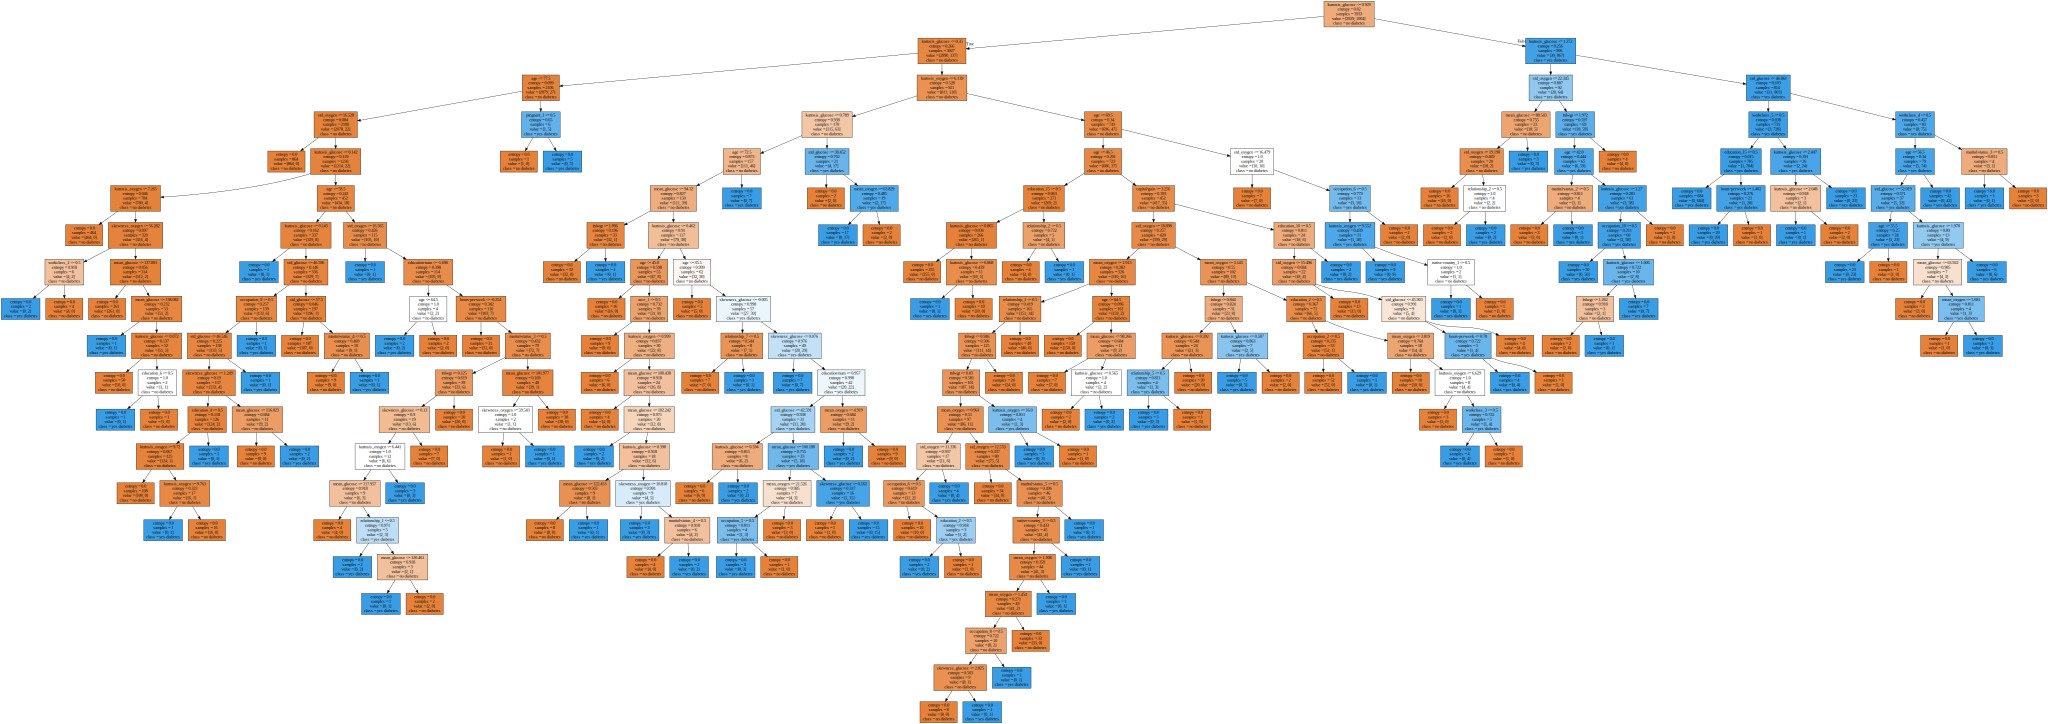

In [4]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=X.columns,
                               class_names=['no diabetes', 'yes diabetes'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

Upravenie validacnych dat priprava na pouztie v strome, pouzitie encoderu a transformovanie.

In [5]:
val_merged_data = pd.read_csv('validate_datas.csv',index_col=0)
# val_merged_data.info()
val_merged_data = val_merged_data.drop(['name', 'address', 'date_of_birth'], axis = 1)
categoric = val_merged_data.select_dtypes(include = ['object'])
transformed = encoder.transform(categoric)

val_merged_data = val_merged_data.drop(categoric, axis = 1)
val_merged_data = val_merged_data.merge(transformed, left_index=True, right_index=True)

Zistili sme, ze validacne data obsahuju v stlpci 'class' dve hodnoty NaN. Zaznamy obsahujuce tieto
hodnoty sme sa rozhodli odtranit z datasetu.

In [6]:
val_merged_data = val_merged_data.dropna()
val_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1310
Columns: 117 entries, education-num to workclass_7
dtypes: float64(15), int64(102)
memory usage: 1.2 MB


Prezenieme vsetky validacne data stromov a skontrolujeme aku presnost sme dosiahli. 
Ulozime si predikciu a nasledne ju budeme kontrolovat s povodnymi hodnotami stlpca 'class'.

In [7]:
prediction = cls.predict(val_merged_data[val_merged_data.columns.difference(['class'])])

In [8]:
print(classification_report(val_merged_data['class'],prediction, digits=3))

              precision    recall  f1-score   support

         0.0      0.971     0.947     0.959       963
         1.0      0.862     0.922     0.891       346

    accuracy                          0.940      1309
   macro avg      0.917     0.935     0.925      1309
weighted avg      0.942     0.940     0.941      1309



### 4. bod - Optimalizacia hyperparametrov

Vyuzijeme GridSearch, pricom budeme vyuzivat 4 rozne hyperparametre, ktore mozeme menit a to su: 
* max depth - zvolili sme interval <2, 27> (ide o maximalnu hlbku stromu)
* criterion - zvolili sme bud gini alebo entropy (ide o funkciu na meranie kvality rozdelovania intervalov)
* min sample leaf - zvolili sme interval <1, 5> (ide o minimalny pocet hodnot, ktore musi obsahovat kazdy list)
* splitter - zvolili sme best alebo random (ide o strategiu rozdelovania pri kazdom uzle)
* max_leaf_nodes - zvolili sme interval <20, 25> (ide o maximalny pocet listov, ktory moze mat jeden uzol)


GridSearch sme si zvolili, aby sme odhalili najlepsie riesenie. Kedze teraz uz mame silny stroj (i7 8750H, 6 jadier, base speed 2.20GHz, max speed 4.1GHz) a nie su kladene podmienky na casovu narocnost. Vdaka tomu, ze si to mozeme dovolit, sme nevyuzili RandomSearch.

In [9]:
clf = DecisionTreeClassifier

cv_params = {'max_depth': list(range(2,20,1)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': list(range(1,6,1)), 'splitter':  ['best', 'random'], 'max_leaf_nodes' : list(range(20,26,1))}
ind_params = {'random_state': 0}
optimization = GridSearchCV(clf(**ind_params), 
                            cv_params, 
                             scoring = 'f1_macro', cv = 10, n_jobs = -1, verbose=True)

Rozdelili sme si trenovaci dataset a ten sme priradili do X a y. Pricom v X su data bez stplca 'class' a y obsahuje stlpec 'class' teda hodnoty, ktore chceme predikovat.

In [10]:
X = merged_data[merged_data.columns.difference(['class'])]
y = merged_data['class']

Natrenujeme si stromy, pricom skusame rozne parametre, ktore sme si zadefinovali v GridSearch. A taktiez sledujume cas tohto trenovania.

In [11]:
%%time
optimization.fit(X, y)

Fitting 10 folds for each of 2160 candidates, totalling 21600 fits
CPU times: user 33.7 s, sys: 1.04 s, total: 34.8 s
Wall time: 2min 51s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 2279 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 4379 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 7079 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 10379 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 14279 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 18779 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 21600 out of 21600 | elapsed:  2.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=0,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
  

Vdaka cv results mozeme vidiet jednotlive vysledky, ktore dosahuje GridSearch pri jednotlivych kombinaciach parametrov.

In [12]:
# optimization.cv_results_

Zistime si parametre, ktore dosahuju najlepsie vysledky. Z tych, co sme zadali do GridSearch to su:
* max depth = 7
* criterion = entropy
* min samples leaf = 2
* splitter = random
* max leaf nodes = 25


Tato kombinacia parametrov dosiahla skore 94.56% na trenovacom datasete.

In [13]:
optimization.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=25,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='random')

In [14]:
optimization.best_score_

0.9456087715868917

Najprv si rozdelime validacne data, rovnakym sposobom ako trenovacie.

In [15]:
X = val_merged_data[merged_data.columns.difference(['class'])]
y = val_merged_data['class']

Spustime predikciu nad validacnymi datami.

In [16]:
prediction = optimization.best_estimator_.predict(X)

Hyperparametre, ktore boli optimalizovane pomocou GridSearch, naslednym vytvorenim stromu s tymito hyperparametrami sme dosiahli precision 95.5%, recall 94.4% a accuracy 96.1%.

Skusali sme aj ine parametre 
* 'max_features': [4] (ide o pocet ficur, ktore sa zvazuju pri hladani najlepsieho rozdelenia)

ktore vsak nijako neovplyvnili vysledok v pozitivny prospech, praveze ho zhorsili a dosiahli sme s nimi precision 90.9% a recall 89.4%.

Po vyskusani odstranenia jednotlivych definovanych parametrov (min samples leaf, splitter) sa precision a recall nijako nezmenili, no pokial sme odstranili max leaf, precision nam klesla na 93.9% a recall velmi mierne stupol na 93.9%.



print(classification_report(y ,prediction, digits=3))

In [68]:
print(classification_report(y ,prediction, digits=3))

              precision    recall  f1-score   support

         0.0      0.967     0.980     0.974       963
         1.0      0.943     0.908     0.925       346

    accuracy                          0.961      1309
   macro avg      0.955     0.944     0.949      1309
weighted avg      0.961     0.961     0.961      1309

